Universidad del Valle de Guatemala

Facultad de Ingeniería

Departamento de Ciencias de la Computación

CC3084 – Data Science

# Laboratio 5
## Clasificación de tweets usando minería de texto

Daniel Valdez - 21240

Emilio Solano - 21212

In [17]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

### Carga y descripción de datos


#### Evaluación del dataset

In [6]:
df = pd.read_csv('train.csv')

In [7]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [10]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


#### Verificar y tratar valores nulos

In [11]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [12]:
df['keyword'].fillna('', inplace=True)
df['location'].fillna('Unknown', inplace=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_6924\2566547448.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['keyword'].fillna('', inplace=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_6924\2566547448.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

In [13]:
df.head()

,id,keyword,location,text,target
0,1,,Unknown,Our Deeds are the Reason of this #earthquake M...,1
1,4,,Unknown,Forest fire near La Ronge Sask. Canada,1
2,5,,Unknown,All residents asked to 'shelter in place' are ...,1
3,6,,Unknown,"13,000 people receive #wildfires evacuation or...",1
4,7,,Unknown,Just got sent this photo from Ruby #Alaska as ...,1


### Preprocesamiento de datos

#### Limpieza

In [19]:
# Descargar stopwords si no están disponibles
nltk.download('stopwords')

# Convertir a minúsculas
df['cleaned_text'] = df['text'].str.lower()

# Eliminar URLs
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'http\S+', '', x))

# Eliminar menciones, hashtags, caracteres especiales y números
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'@\w+|#\w+|\W|\d+', ' ', x))

# Eliminar stopwords
stop_words = set(stopwords.words('english'))
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# Mostrar las primeras filas del texto limpiado
df['cleaned_text'].head()

0                    deeds reason may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3          people receive evacuation orders california
4               got sent photo ruby smoke pours school
Name: cleaned_text, dtype: object

#### Análisis de frecuencia

In [22]:
# Unigramas
disaster_words = ' '.join(df[df['target'] == 1]['cleaned_text']).split()
nondisaster_words = ' '.join(df[df['target'] == 0]['cleaned_text']).split()

disaster_freq = Counter(disaster_words)
nondisaster_freq = Counter(nondisaster_words)

In [23]:
disaster_freq.most_common(10)

[('fire', 180),
 ('û_', 172),
 ('amp', 135),
 ('via', 121),
 ('disaster', 113),
 ('suicide', 112),
 ('california', 111),
 ('police', 108),
 ('people', 104),
 ('killed', 94)]

In [24]:
nondisaster_freq.most_common(10)

[('like', 254),
 ('amp', 209),
 ('û_', 172),
 ('new', 170),
 ('get', 163),
 ('one', 131),
 ('body', 115),
 ('would', 101),
 ('via', 99),
 ('people', 94)]

### Análisis exploratorio

#### Nube de palabras

Nube de palabras para tweets de desastres


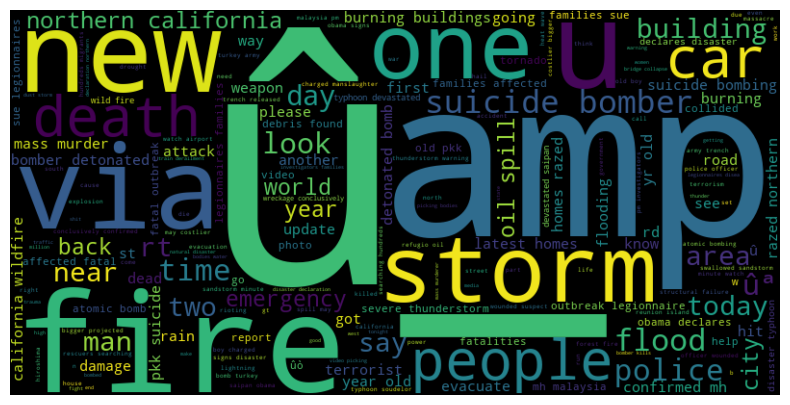

Nube de palabras para tweets no relacionados con desastres


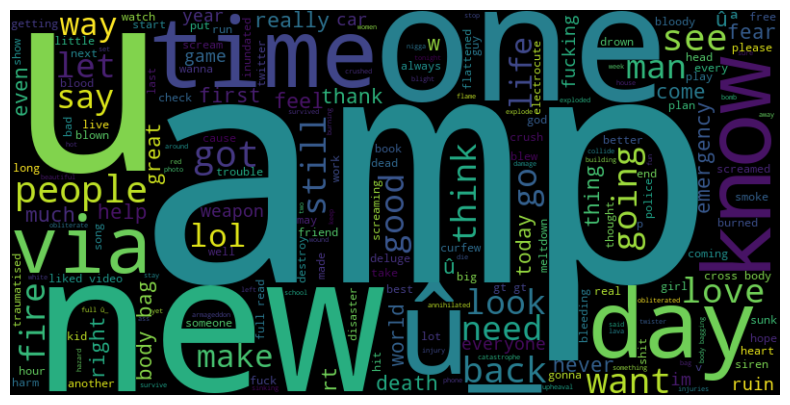

In [26]:
print('Nube de palabras para tweets de desastres')
disaster_wordcloud = WordCloud(width=800, height=400).generate(' '.join(disaster_words))
plt.figure(figsize=(10, 5))
plt.imshow(disaster_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

print('Nube de palabras para tweets no relacionados con desastres')
nondisaster_wordcloud = WordCloud(width=800, height=400).generate(' '.join(nondisaster_words))
plt.figure(figsize=(10, 5))
plt.imshow(nondisaster_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Histogramas de frecuencia

Histograma de palabras más frecuentes
Plot histogram


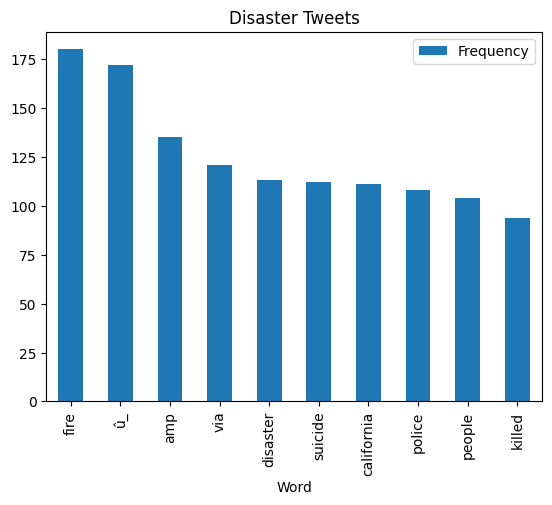

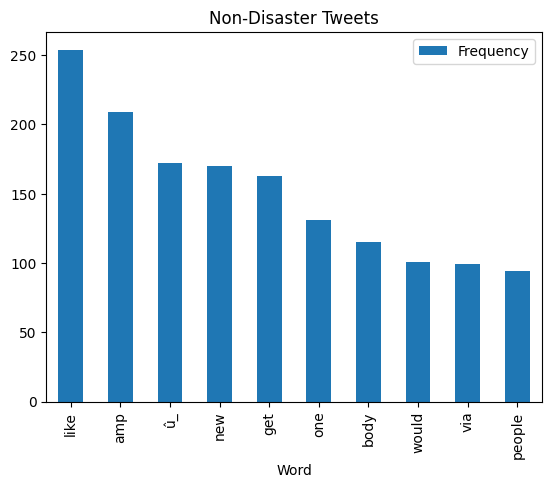

In [27]:
print('Histograma de palabras más frecuentes')
disaster_common_words = disaster_freq.most_common(10)
nondisaster_common_words = nondisaster_freq.most_common(10)

disaster_df = pd.DataFrame(disaster_common_words, columns=['Word', 'Frequency'])
nondisaster_df = pd.DataFrame(nondisaster_common_words, columns=['Word', 'Frequency'])

print('Plot histogram')
disaster_df.plot(kind='bar', x='Word', y='Frequency', title='Disaster Tweets')
nondisaster_df.plot(kind='bar', x='Word', y='Frequency', title='Non-Disaster Tweets')
plt.show()

### Modelo preliminar

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['target'], test_size=0.2, random_state=42)

# Vectorizar el texto
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Entrenar un modelo preliminar
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.78      0.88      0.83       874
           1       0.81      0.67      0.73       649

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.79      0.79      1523

